In [3]:
import os
from astropy.io import fits
import time
from matplotlib import pyplot as plt
%matplotlib inline
import glob
import numpy as np
from astropy.io import ascii
from astropy.table import Table

## Reducing 2019 Data From INT

* create mosaics with theli.  
  * notes are here: https://docs.google.com/document/d/1RvXv-4K5p9EMDesxOOPoQoCIBwRo2NpHD7hstGAOLgk/edit?usp=sharing
  * reduction log: https://docs.google.com/spreadsheets/d/175ya3b6pd3sc_uHtmR6vmNi1wPBC4bSV9DMTG8od4_E/edit?usp=sharing
  * doing reduction on linux laptop b/c I could install theli here
  
* gather coadds in a directory 

* zeropoint calibration
  * where is the best place to do this?  in each coadd directory, or gather all coadds first, then run altogether
  * the advantage of the latter is that all of the diagnostic plots will be in the same directory
  * TO DO
      * need to make a plots subdirectory, and save plots from getzp there. - DONE
      * also need to rename plots to include coadd name - DONE
* at this point, we can move the reduced data to virgo vms virgo-gdrive and also backup on an external harddrive
* cp coadds to virgo vms, virgo-gdrive

## Update on INT reduction as of Feb 2020

* used theli v3 through flatfielding
* moved images from virgo vms to laptop b/c file i/o on vms was super slow
  * ~/data/reduced/scratch-int-feb2019/
  * attempt2 subdirectory is the *final* version
* then pooled all images to one directory and ran scamp on all images at once
  * INT_scamp_swarp.py
* then split images into directories, one for each pointing
  * INT_gather_pointing_images.py
* create mosaics
  * subtracted the median sky value from each chip using: 
    * HalphaImaging/python3/subtract_median.py
    * INT_scamp_swarp.py
    
  * then ran swarp to create the mosaics
    * INT_scamp_swarp.py
    
* solved for ZP in individual directories
  * github/HalphaImaging/python3/INT_batch_getzp.py
    * this also divides by exposure time - swarp used to do this, but 
* move images to a coadd directory
  * ~/data/reduced/virgo-coadds-feb2019-int
  * INT_gathercoadds_notheli.py
    * this creates image name that contains RA, DEC, date, pointing number
    * also adds AIRMASS and DATE-OBS to the header of the coadd by grabbing the info from one of the individual exposures
      * I would like my students to make plots of ZP versus time/date and airmass



## Next Steps
* align images - write batch for this 
  * **INT_align_images.py**
  * DONE
* get psf for each image
  * doing this ahead of running gui
  * **INT_batch_buildpsf.py**
  * DONE?
  


# Align Images

* could not get reproject_exact to work, so I'm sticking with reproject_interp
* the shifted weight image was ended up double the size of the unshifted.  trying to figure out how to preserve the data type. DONE

In [ ]:
os.chdir('/home/rfinn/data/reduced/virgo-coadds-feb2019-int')

In [ ]:
start_time = time.perf_counter()
%run ~/github/HalphaImaging/python3/INT_batch_align_images.py
end_time = time.perf_counter()
print('\t total time = ',end_time - start_time)


### didn't complete for p059 for some reason

* Halpha and r-band data are taken on a different night - that must be why.
* FIXED

In [ ]:
!ls *p059*

In [ ]:
%run ~/github/HalphaImaging/python3/INT_align_images.py --image1 VF-158.8058+37.4986-INT-20190211-p059-Halpha.fits  --image2 VF-158.8058+37.4986-INT-20190210-p059-r.fits --weight2 VF-158.8058+37.4986-INT-20190210-p059-r.weight.fits  

# Build PSF models

In [ ]:
os.chdir(homedir+'/data/reduced/psf-images/')


In [ ]:
%run ~/github/HalphaImaging/python3/INT_batch_buildpsf.py

### Bad PSF models - FIXED

* looking through fits images to see if there are any odd PSFs
  * set display to z1=-.001, z2=.05
  * then use pyraf.imexam to look at all images
* found these
 
| Image | Comments | Date |
|-------|----------|-|
|lmp001-Halpha | pixelated, mild| 20190207 |
|p012-Halpha | pixelated, bumpier than normal | 20190205 |
|p012-r | pixelated |  20190205 |
|p013-Halpha | yuck - pixelated, triangular shape | 20190206|
|p013-r | pixelated | 20190206|
|p016-Halpha | pixelated, checkerboard (maybe an issue w/oversampling?| 20190205 |
|p016-r | ditto | |
|p017-Halpha | pixelated, barf| 20190206 |
| p017-r | not as bad | |
|p023-Halpha | pixelated, checkerboard| 
|p050-r | pixelated, checkerboard| 20190206 |
|p059-r | pixelated, checkerboard| 20190210 |
|p059-Halpha | pixelated, checkerboard| 20190210 |
|p072-r | pixelated, barf; in coadd all stars have a hole in center| 20190211 | 
|p081-Halpha | pixelated, mild| 20190211 |
|p081-r | ditto| 20190211 |

* I redid psf measurements.  I added a smoothing kernal ('quadratic') and increased the box size from 35 to 39 b/c some of the more problematic psfs seems to have larger fwhm.

    * p072-r looks great
    * p013-Halpha looks good to (except for noise on rhs of psf image...)
    
* also decreased the saturation thresholds to 100 (r) and 30 (Halpha)


#### Rebuilding all PSFs so they are made the same way

Hopefully nothing else breaks...
    

### Checking number of files - found problems

* noticed in PSF folder that some images had multiple (>2) psf images
  * first time I moved coadds using INT_gathercoadds_notheli.py, I used the first image in the stack to get the date of the observation
  * second time I used the middle image.  In a few cases, this changed the date of the observation b/c the data were taken right around midnight UT.  
  * I didn't delete the first set before running for the second time, so I ended up with a few double images.
* pointing026 had Halpha only
  * check logged, and r-band data had pointing022 as the object name
      * I'm sure I changed that like 100 times, but ....
      * rband coadds were 5G for pointing 022
  * I moved the p026 rband images from p022 to p026
  * then need to reconstruct the coadds for these two pointings
      * run INT_scamp_swarp
  

In [ ]:
os.chdir(homedir+'/data/reduced/scratch-int-feb2019/attempt2/')
%run ~/github/HalphaImaging/python3/INT_scamp_swarp.py

Then

* getzp
  * updated spreadsheet in reduction log https://docs.google.com/spreadsheets/d/175ya3b6pd3sc_uHtmR6vmNi1wPBC4bSV9DMTG8od4_E/edit?usp=sharing


In [ ]:
os.chdir(homedir+'/data/reduced/scratch-int-feb2019/attempt2/')
%run ~/github/HalphaImaging/python3/INT_batch_getzp.py

* move coadds
  * set flist1 = ['pointing022','pointing026'] in INT_gathercoadds_notheli.py
  
  * then run

In [ ]:
os.chdir(homedir+'/data/reduced/scratch-int-feb2019/attempt2/')
%run ~/github/HalphaImaging/python3/INT_gathercoadds_notheli.py

### align the images

In [ ]:
os.chdir(homedir+'/data/reduced/virgo-coadds-feb2019-int/')
%run ~/github/HalphaImaging/python3/INT_batch_align_images.py

# Adding INT Filters

* the filter traces for the KPNO filters are in /home/rfinn/github/halphagui/filter_traces
* need to get data for the INT filters
http://catserver.ing.iac.es/filter/list.php?instrument=WFC

## To Do

* download filters - DONE
* update filter_transmission.py - DONE
* update connect_ha_menu in halphamain.py - DONE
* update gui - DONE
  * start ui
  * add buttons
  * save ui
  * convert to python (see readme https://github.com/rfinn/halphagui)
  * update library in photwrapper.py with central wavelength and width
  * good to go!

In [ ]:
filterpath = '/home/rfinn/github/halphagui/filter_traces/'
os.chdir(filterpath)

In [ ]:
!ls


In [ ]:
ffiles = glob.glob('*.txt')
ffiles.sort()
print(ffiles)

In [ ]:
plt.figure(figsize=(8,6))
for f in ffiles:
    print(f)
    wave,trans = np.loadtxt(f,unpack=True)
    if f.startswith('ha1'): # skip ha12 and ha16
        continue
    if f.startswith('ha8'):
        continue
    if f.startswith('wfc'):
        wave = wave*10
    plt.plot(wave,trans,label=f)
plt.legend(loc='lower left')
plt.xlim(5500,7250)
plt.title('Halpha and Broad Filters',fontsize=20)
plt.xlabel('Wavelength (A)',fontsize=16)
plt.ylabel('Transmission (%)',fontsize=16)
plt.show()


In [ ]:
plt.figure(figsize=(8,6))
for f in ffiles:
    print(f)
    wave,trans = np.loadtxt(f,unpack=True)
    if f.startswith('ha1'): # skip ha12 and ha16
        continue
    if f.startswith('ha8'):
        continue
    if f.startswith('wfc'):
        wave = wave*10
    plt.plot(wave,trans,label=f)
plt.legend(loc='lower left')
plt.xlim(6475,6775)
plt.title('Halpha and Broad Filters',fontsize=20)
plt.xlabel('Wavelength (A)',fontsize=16)
plt.ylabel('Transmission (%)',fontsize=16)
plt.gca().grid(True)
plt.show()


In [ ]:
# show in terms of vr
# vr = c*(wave/6563-1)
plt.figure(figsize=(8,6))
for f in ffiles:
    print(f)
    wave,trans = np.loadtxt(f,unpack=True)
    if f.startswith('ha1'): # skip ha12 and ha16
        continue
    if f.startswith('ha8'):
        continue
    if f.find('r') > -1:
        continue
    if f.find('R') > -1:
        continue
    if f.startswith('wfc'):
        wave = wave*10
    vr = 3.e5*(wave/6563-1)
    plt.plot(vr,trans,label=f.split('.txt')[0])
plt.legend(loc='lower left')

plt.xlim(0,5000)
plt.title('Halpha Filters',fontsize=20)
plt.xlabel('Recession Velocity (km/s)',fontsize=16)
plt.ylabel('Transmission (%)',fontsize=16)
plt.gca().grid(True)
plt.axvline(x=2400,c='k',ls='--')
plt.show()



In [ ]:
t = ascii.read(f)

In [ ]:
t

In [ ]:
(6610-6563)/6563*3e5


# Finishing INT Reduction


* continue with data from Nelvy
* data are on Virgo vms in /mnt/astrophysics/reduced/2019nelvy-all

* abandon data from beginning of may - too many problems...


# Next Steps

## Last Steps of Reduction

* look into problematic pointings from Feb 2019
  * pointing005 in /home/rfinn/data/reduced/scratch-int-feb2019/problems
  * maybe others? NO!
    * there is data from pointing004 from 0204, but we redid this on 0205
    * lmpointing008 - only has r-band data
    
## Halpha Analysis

* add INT filters to halphagui
* run halphagui
    * create cutouts
      * need to make sure we are using v1 of virgo filament catalog - DONE
    * make masks
    * run through photometry
    * catalog any additional emitters
        * make sure the continuum-subtracted mosaic is saved
    * this is going to take A LONG TIME!!!
    * I will check how long.  wondering if gui is not the right way to do this, because it is so interactive.  would be good to identify sources and create masks using the gui, but then run the photometry in a more automated way.
    * would need code to gather output from photometry into tables, like is done in the gui.
    * I've done 111 galaxies with the gui so far, from 33 pointings...
    * INT data has about 90 pointings.
* there is an auto switch on the gui - not sure what this does
* tables from gui are in ~/research/Virgo/halpha-tables/
* also need to update write_subtables to use match to the halpha output by RA and DEC, rather than VFID.  This will enable us to incorporate the results that were based on the v0 catalog, rather than having to redo them. DONE



## How to make the data available and viewable in a user-friendly way

* siena faculty websites
  * could host just the png images there
* continue with cutout images on virgo vms 
  * the code has improved, so these images will look better

# Running GUI on INT Coadds

* I am now up to the point where I can run the gui on the coadded images!  
* I am going to make some changes to halphagui.py to set up for running on the INT data, and then I will try running in auto mode.  We can then go through and check which masks are incorrect and redo the analysis for those galaxies.

In [ ]:
os.chdir('/home/rfinn/research/Virgo/gui-output-2019/')

In [ ]:
%run ~/github/halphagui/testing/halphamain.py --help

# Checking photometry numbers of INT

* ran first example v19p001.  photometry results say profile is not deep enough to high R23, R24, or R25
* want to compare with galfit says
* galaxy is CGCG 118-019
* magnitudes
  * galfit says m=10.39
  * NED says sdss model mag in r is 14.14

In [ ]:
galfit_mag = 10.3958
fluxzp = 3631 # AB, JY


# Update Halpha Data Tables

* combine Halpha tables from different gui sessions

* rebuild virgo filament v1 tables

# Update as of March 8, 2021

* I redid se, scamp and swarp on the HDI images - did this on virgovms, in /mnt/qnap_home/rfinn/Halpha/.  The reason was to NOT have swarp model the background in the images.
* all HDI coadds from all years are in the same directory - this is easiest way to proceed
* ran getzp in batch mode.  tried two cycles, but I think one is best because rms seems to increase after second pass.  need to check that for all images.  Figures created from getzp are in subdirectory of coadd folder called plots.
* ran buildpsf in batch mode.  the psf files are on virgovms and on laptop in
```
~/data/reduced/psf-images/
```

## Displaying Results as Web pages
* I have built webpages to display results from coadds
```
~/github/Virgo/programs/build_web_coadds.py
```
* and cutouts
```
~/github/Virgo/programs/build_web_cutouts.py
```
* and then make an index page for each
```
~/github/Virgo/programs/build_index_coadds.py
~/github/Virgo/programs/build_index_cutouts.py
```

* I run both of these from ~/research/Virgo/html-dev
* can then copy the resulting directories to facultyweb
```
scp -r * facultyweb.siena.edu:public_html/virgo
```

* results appear at https://facultyweb.siena.edu/~rfinn/virgo/

## Naming conventions
* I have updated the HDI coadd names to 
```
VF-2017-05-20-HDI-p004
```
* I have updated the gui to append to the cutout directory name the dateobs, instrument, and pointing.  this will prevent the cutouts from different runs/telescopes from overwriting each other.

## Still to do

### COADDS
* rename INT coadds to format
```
VF-2017-05-20-HDI-p004
```
  * get rid of "shifted" in r-band coadd name, or move it before coadd
  
* I have run the build_web_coadds.py on the HDI data - need to now run on the INT data
  * I do not have the zp images readily available for the INT data - the files are in separate subdirectories in the data folder. 
  * so I either need to gather up the images and rename them, or rerun getzp
  * problem with rerunning getzp is that the coadd images have already been flattened, so would have to go back to the data directories.
  * **solution: gather up images**
  
* alternative to the above is to write a separate build command for the INT data, until I get the zp issue worked out.
* when finished, scp results for coadds to facultyweb


### CUTOUTS
* run gui in auto mode on the updated HDI mosaics
* run plot_cutouts_ha.py in batch mode to pull all the multiwavelength data
```
~/github/HalphaImaging/python3/generate_all_cutout_plots.py
```
* run 
```
build_web_cutouts.py
```
* I can't think of any reason why this wouldn't work on the HDI data, so this might be the easier task to start with.

* rerun gui on INT data because current directory names are not the final version.  I don't think this has to wait for the INT coadds to be renamed, because the output directory name is taken from galaxy properties and header info in the halpha image.

### General
* make a home page for ~/rfinn/virgo/
* decide if we want to password-protect the Halpha cutout and coadd pages for now?

# Running auto gui on HDI coadds

* made a directory 
```
/home/rfinn/research/Virgo/gui-output-all-hdi-20210308
```

* going to run auto gui here.

```
python ~/github/halphagui/batch_gui.py --coaddir /home/rfinn/data/reduced/virgo-coadds-HDI/ --hdi

```

* then

```
python ~/github/HalphaImaging/python3/generate_all_cutout_plots.py
```

and from cutouts directory

```
python ~/github/Virgo/programs/build_web_cutouts.py
```

# Looking for a new way to stack the tables from the halpha gui

* For whatever reason, astropy.table.vstack is really slow.  
* put most recent files in 

```
~/research/Virgo/halpha-tables-20210311

```


In [ ]:
os.chdir('/home/rfinn/research/Virgo/halpha-tables-20210311/')

In [ ]:
from astropy.io import fits

In [ ]:
%run ~/github/Virgo/programs/stack-gui-halpha-tables.py

# Inspecting Merged Halpha Table

* opened in topcat

```
/home/rfinn/research/Virgo/halpha-tables-20210311/halphagui-output-combined-2021-Mar-11.fits

```


In [9]:
hcat = Table.read('/home/rfinn/research/Virgo/halpha-tables-20210311/halphagui-output-combined-2021-Mar-11.fits')

In [10]:
hcat

VFID,RA,DEC,vr,radius,NEDname,prefix,HAflag,REDSHIFT,ZDIST,GAL_RA,GAL_DEC,GAL_HRA,GAL_HDEC,ELLIP_RA,ELLIP_DEC,HA_FLAG,FILT_COR,R_FWHM,H_FWHM,POINTING,BBOX,FILTER_RATIO,GAL_XC,GAL_XC_ERR,GAL_YC,GAL_YC_ERR,GAL_MAG,GAL_MAG_ERR,GAL_RE,GAL_RE_ERR,GAL_N,GAL_N_ERR,GAL_BA,GAL_BA_ERR,GAL_PA,GAL_PA_ERR,GAL_SKY,GAL_CHISQ,GAL_2SERSIC [15],GAL_2SERSIC_ERR [15],GAL_2SERSIC_ERROR,GAL_2SERSIC_CHISQ,GAL_SERSASYM [10],GAL_SERSASYM_ERR [10],GAL_SERSASYM_ERROR,GAL_SERSASYM_CHISQ,GAL_SERSASYM_RA,GAL_SERSASYM_DEC,GAL_HXC,GAL_HXC_ERR,GAL_HYC,GAL_HYC_ERR,GAL_HMAG,GAL_HMAG_ERR,GAL_HRE,GAL_HRE_ERR,GAL_HN,GAL_HN_ERR,GAL_HBA,GAL_HBA_ERR,GAL_HPA,GAL_HPA_ERR,GAL_HSKY,GAL_HCHISQ,GAL_H2SERSIC [15],GAL_H2SERSIC_ERR [15],GAL_H2SERSIC_ERROR,GAL_H2SERSIC_CHISQ,GAL_HSERSASYM [10],GAL_HSERSASYM_ERR [10],GAL_HSERSASYM_ERROR,GAL_HSERSASYM_CHISQ,GAL_HSERSASYM_RA,GAL_HSERSASYM_DEC,ELLIP_XCENTROID,ELLIP_YCENTROID,ELLIP_EPS,ELLIP_THETA,ELLIP_GINI,ELLIP_GINI2,ELLIP_AREA,ELLIP_SUM,ELLIP_SUM_MAG,ELLIP_ASYM,ELLIP_ASYM_ERR,ELLIP_HSUM,ELLIP_HSUM_MAG,ELLIP_HASYM,ELLIP_HASYM_ERR,R_SKYNOISE,H_SKYNOISE,GAL_R24,GAL_R24_ERR,GAL_R25,GAL_R25_ERR,GAL_R26,GAL_R26_ERR,GAL_R_F25,GAL_R_F25_ERR,GAL_R24V,GAL_R24V_ERR,GAL_R25V,GAL_R25V_ERR,GAL_R_F50,GAL_R_F50_ERR,GAL_R_F75,GAL_R_F75_ERR,GAL_M24,GAL_M24_ERR,GAL_M25,GAL_M25_ERR,GAL_M26,GAL_M26_ERR,GAL_F_30R24,GAL_F_30R24_ERR,GAL_F_R24,GAL_F_R24_ERR,GAL_C30,GAL_C30_ERR,GAL_PETRO_R,GAL_PETRO_R_ERR,GAL_PETRO_FLUX,GAL_PETRO_FLUX_ERR,GAL_PETRO_R50,GAL_PETRO_R50_ERR,GAL_PETRO_R90,GAL_PETRO_R90_ERR,GAL_PETRO_CON,GAL_PETRO_CON_ERR,GAL_PETRO_MAG,GAL_PETRO_MAG_ERR,GAL_HR16,GAL_HR16_ERR,GAL_HR17,GAL_HR17_ERR,GAL_HR_F25,GAL_HR_F25_ERR,GAL_HR_F50,GAL_HR_F50_ERR,GAL_HR_F75,GAL_HR_F75_ERR,GAL_HM16,GAL_HM16_ERR,GAL_HM17,GAL_HM17_ERR,GAL_HF_30R24,GAL_HF_30R24_ERR,GAL_HF_R24,GAL_HF_R24_ERR,GAL_HC30,GAL_HC30_ERR,GAL_HR_F95R24,GAL_HR_F95R24_ERR,GAL_HF_TOT,GAL_HF_TOT_ERR,GAL_HPETRO_R,GAL_HPETRO_R_ERR,GAL_HPETRO_FLUX,GAL_HPETRO_FLUX_ERR,GAL_HPETRO_R50,GAL_HPETRO_R50_ERR,GAL_HPETRO_R90,GAL_HPETRO_R90_ERR,GAL_HPETRO_CON,GAL_HPETRO_CON_ERR,GAL_HPETRO_MAG,GAL_HPETRO_MAG_ERR,GAL_LOG_SFR_HA,GAL_LOG_SFR_HA_ERR,GAL_SSFR_IN,GAL_SSFR_IN_ERR,GAL_SSFR_OUT,GAL_SSFR_OUT_ERR,R24,R24_ERR,R25,R25_ERR,R26,R26_ERR,R_F25,R_F25_ERR,R24V,R24V_ERR,R25V,R25V_ERR,R_F50,R_F50_ERR,R_F75,R_F75_ERR,M24,M24_ERR,M25,M25_ERR,M26,M26_ERR,F_30R24,F_30R24_ERR,F_R24,F_R24_ERR,C30,C30_ERR,PETRO_R,PETRO_R_ERR,PETRO_FLUX,PETRO_FLUX_ERR,PETRO_R50,PETRO_R50_ERR,PETRO_R90,PETRO_R90_ERR,PETRO_CON,PETRO_CON_ERR,PETRO_MAG,PETRO_MAG_ERR,HR16,HR16_ERR,HR17,HR17_ERR,HR_F25,HR_F25_ERR,HR_F50,HR_F50_ERR,HR_F75,HR_F75_ERR,HM16,HM16_ERR,HM17,HM17_ERR,HF_30R24,HF_30R24_ERR,HF_R24,HF_R24_ERR,HC30,HC30_ERR,HR_F95R24,HR_F95R24_ERR,HF_TOT,HF_TOT_ERR,HPETRO_R,HPETRO_R_ERR,HPETRO_FLUX,HPETRO_FLUX_ERR,HPETRO_R50,HPETRO_R50_ERR,HPETRO_R90,HPETRO_R90_ERR,HPETRO_CON,HPETRO_CON_ERR,HPETRO_MAG,HPETRO_MAG_ERR,LOG_SFR_HA,LOG_SFR_HA_ERR,SSFR_IN,SSFR_IN_ERR,SSFR_OUT,SSFR_OUT_ERR,CONTSUB_FLAG,MERGER_FLAG,SCATLIGHT_FLAG,ASYMR_FLAG,ASYMHA_FLAG,OVERSTAR_FLAG,OVERGAL_FLAG,PARTIAL_FLAG,EDGEON_FLAG,NUC_HA,COMMENT
bytes8,float64,float64,float64,float32,bytes30,bytes38,bool,float64,float64,float32,float32,float32,float32,float32,float32,bool,float32,float32,float32,bytes10,bytes22,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32

Text(0, 0.5, 'Number of Galaxies')

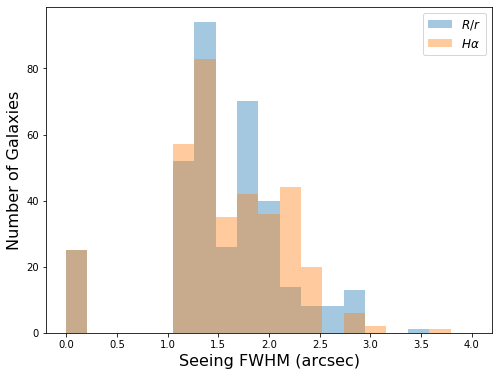

In [23]:
# seeing values
plt.figure(figsize=(8,6))
mybins = np.linspace(0,4,20)
t = plt.hist(hcat['R_FWHM'],bins=mybins,label='$R/r$',alpha=.4)
t = plt.hist(hcat['H_FWHM'],bins=mybins,label=r'$H\alpha$',alpha=.4)
plt.legend(fontsize=12)
plt.xlabel('Seeing FWHM (arcsec)',fontsize=16)
plt.ylabel('Number of Galaxies',fontsize=16)

/home/rfinn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/home/rfinn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


Text(0, 0.5, 'Number of Galaxies')

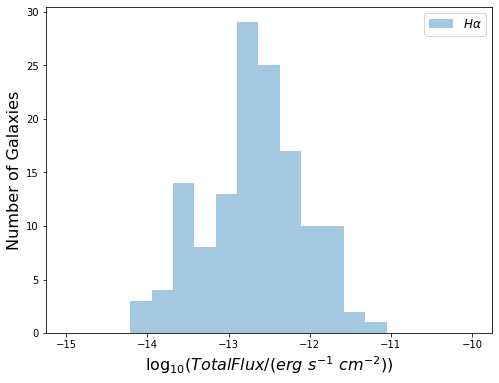

In [28]:
# hist of Halpha flux
# use GAL_HF_TOT
# seeing values
plt.figure(figsize=(8,6))
mybins = np.linspace(-15,-10,20)
t = plt.hist(np.log10(hcat['GAL_HF_TOT']),bins=mybins,label=r'$H\alpha$',alpha=.4)
#t = plt.hist(hcat['H_FWHM'],bins=mybins,label=r'$H\alpha$',alpha=.4)
plt.legend(fontsize=12)
plt.xlabel('$\log_{10}(Total Flux/(erg~s^{-1}~cm^{-2}))$',fontsize=16)
plt.ylabel('Number of Galaxies',fontsize=16)

/home/rfinn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


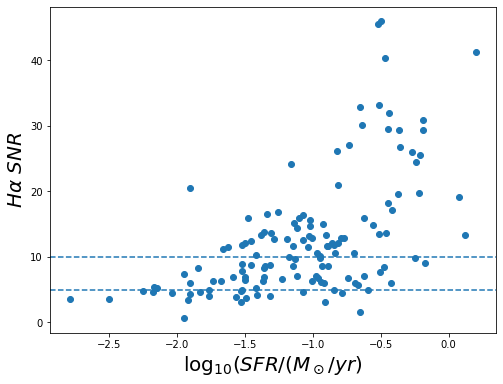

In [40]:
# SNR vs SFR

snr = np.abs(hcat['GAL_HF_TOT']/hcat['GAL_HF_TOT_ERR'])
plt.figure(figsize=(8,6))
plt.plot(hacat['LOG_SFR_HA'],snr,marker='o',ls='None')
plt.xlabel('$\log_{10}(SFR/(M_\odot/yr)$',fontsize=20)
plt.ylabel(r'$H\alpha ~ SNR$',fontsize=20)
plt.axhline(y=5,ls='--')
plt.axhline(y=10,ls='--')

In [42]:
(.9/2.3)**2*1200

183.7429111531191